In [1]:
!pip install pyLDAvis
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


In [3]:
# import package
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# import data
df_ori = pd.read_csv("../smote/data_smote_full.csv")
df_ori = df_ori.filter(['kalimat_asli'])
df = pd.read_csv("../smote/data_smote_full.csv")
df = df.filter(['kalimat_asli'])

# Convert to list
data = df['kalimat_asli'].values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=50, threshold=1)  # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


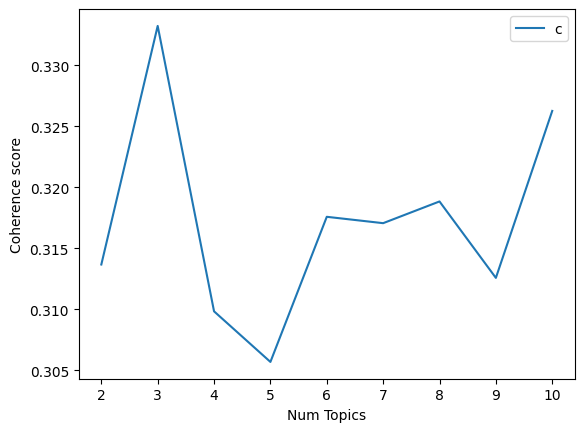

Num Topics = 2  has Coherence Value of 0.314
Num Topics = 3  has Coherence Value of 0.333
Num Topics = 4  has Coherence Value of 0.31
Num Topics = 5  has Coherence Value of 0.306
Num Topics = 6  has Coherence Value of 0.318
Num Topics = 7  has Coherence Value of 0.317
Num Topics = 8  has Coherence Value of 0.319
Num Topics = 9  has Coherence Value of 0.313
Num Topics = 10  has Coherence Value of 0.326


In [ ]:
# import package

import gensim
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

# function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Show graph
limit = 11
start = 2
step = 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

In [5]:
# import package
from pprint import pprint

# Select the model and print the topics
import random
import joblib
import numpy as np

optimal_model = joblib.load('../model/topic_model.joblib')
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

# melabeli data berdasarkan keywords
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_data = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_data.append([int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]])
                break

    sent_topics_df = pd.DataFrame(sent_topics_data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# melihat sentimen dari text original
cek_df = pd.DataFrame([])
cek_df = df_dominant_topic.copy()
cek_df['kalimat_asli'] = df_ori['kalimat_asli'].copy()
cek_df

[(0,
  '0.023*"banget" + 0.022*"pakai" + 0.021*"jerawat" + 0.021*"toner" + '
  '0.020*"kulit" + 0.015*"cocok" + 0.013*"produk" + 0.011*"nya" + '
  '0.011*"wajah" + 0.011*"muka" + 0.010*"jadi" + 0.010*"buat" + 0.009*"bikin" '
  '+ 0.008*"sama" + 0.008*"sih"'),
 (1,
  '0.030*"jerawat" + 0.026*"pakai" + 0.020*"toner" + 0.020*"jadi" + '
  '0.020*"kulit" + 0.011*"cocok" + 0.010*"nya" + 0.010*"banget" + 0.009*"buat" '
  '+ 0.009*"kalau" + 0.008*"produk" + 0.008*"muka" + 0.008*"sama" + '
  '0.007*"lebih" + 0.007*"wajah"'),
 (2,
  '0.021*"banget" + 0.021*"toner" + 0.019*"buat" + 0.019*"pakai" + '
  '0.018*"jerawat" + 0.011*"sih" + 0.010*"kalau" + 0.009*"kulit" + '
  '0.009*"jadi" + 0.009*"cocok" + 0.009*"bikin" + 0.008*"bagus" + 0.008*"sama" '
  '+ 0.007*"muka" + 0.007*"merah"')]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,kalimat_asli
0,0,0,0.6599,"banget, pakai, jerawat, toner, kulit, cocok, p...",mungkin viral kata kemarin nyobain ph sih bau ...,mungkin viral kata kemarin nyobain ph sih bau ...
1,1,0,0.9685,"banget, pakai, jerawat, toner, kulit, cocok, p...",stop ajaa purging gacocok sii dalem bahan taku...,stop ajaa purging gacocok sii dalem bahan taku...
2,2,2,0.9666,"banget, toner, buat, pakai, jerawat, sih, kala...",batu stop tempat jalan minggu timbul putus mak...,batu stop tempat jalan minggu timbul putus mak...
3,3,2,0.6936,"banget, toner, buat, pakai, jerawat, sih, kala...",sold paket wa preloved gatel minggu berat rasa...,sold paket wa preloved gatel minggu berat rasa...
4,4,1,0.4355,"jerawat, pakai, toner, jadi, kulit, cocok, nya...",ig di ering kuat salicylic pori jauh hijau ben...,ig di ering kuat salicylic pori jauh hijau ben...
...,...,...,...,...,...,...
1163,1163,0,0.9488,"banget, pakai, jerawat, toner, kulit, cocok, p...",gabisa jauh bukan ganti jadiin hehe biasa sih ...,gabisa jauh bukan ganti jadiin hehe biasa sih ...
1164,1164,0,0.9463,"banget, pakai, jerawat, toner, kulit, cocok, p...",lalu rasa liat tiktok parah ampuh coba nyata k...,lalu rasa liat tiktok parah ampuh coba nyata k...
1165,1165,0,0.7403,"banget, pakai, jerawat, toner, kulit, cocok, p...",rasa bekas bukan dipake bakal radang ngurangin...,rasa bekas bukan dipake bakal radang ngurangin...
1166,1166,0,0.8557,"banget, pakai, jerawat, toner, kulit, cocok, p...",dipakein hempas isi mula murah langsung cegah ...,dipakein hempas isi mula murah langsung cegah ...


In [7]:
import pandas as pd

# Fungsi untuk melabeli topik
def label_topics(row):
    if row['Dominant_Topic'] == 0:
        return 'Penggunaan Produk'  # Ganti dengan label aspek yang sesuai
    elif row['Dominant_Topic'] == 1:
        return 'Kualitas Produk'  # Ganti dengan label aspek yang sesuai
    elif row['Dominant_Topic'] == 2:
        return 'Pembelian Produk'  # Ganti dengan label aspek yang sesuai
    else:
        return 'Unknown'

# Memanggil fungsi untuk melabeli topik
df_dominant_topic['topic_label'] = df_dominant_topic.apply(label_topics, axis=1)

# Load dataset hasilpreproses.csv
df_preprocessed = pd.read_csv('../smote/data_smote_full.csv')

# Menambahkan kolom sentimen dari kolom polarity
df_dominant_topic['sentimen'] = df_preprocessed['sentimen']

# Melihat hasil
cek_df = df_dominant_topic.copy()
cek_df['Kalimat_asli'] = df_ori['kalimat_asli'].copy()

cek_df



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic_label,sentimen,Kalimat_asli
0,0,0,0.6599,"banget, pakai, jerawat, toner, kulit, cocok, p...",mungkin viral kata kemarin nyobain ph sih bau ...,Penggunaan Produk,0,mungkin viral kata kemarin nyobain ph sih bau ...
1,1,0,0.9685,"banget, pakai, jerawat, toner, kulit, cocok, p...",stop ajaa purging gacocok sii dalem bahan taku...,Penggunaan Produk,0,stop ajaa purging gacocok sii dalem bahan taku...
2,2,2,0.9666,"banget, toner, buat, pakai, jerawat, sih, kala...",batu stop tempat jalan minggu timbul putus mak...,Pembelian Produk,0,batu stop tempat jalan minggu timbul putus mak...
3,3,2,0.6936,"banget, toner, buat, pakai, jerawat, sih, kala...",sold paket wa preloved gatel minggu berat rasa...,Pembelian Produk,0,sold paket wa preloved gatel minggu berat rasa...
4,4,1,0.4355,"jerawat, pakai, toner, jadi, kulit, cocok, nya...",ig di ering kuat salicylic pori jauh hijau ben...,Kualitas Produk,0,ig di ering kuat salicylic pori jauh hijau ben...
...,...,...,...,...,...,...,...,...
1163,1163,0,0.9488,"banget, pakai, jerawat, toner, kulit, cocok, p...",gabisa jauh bukan ganti jadiin hehe biasa sih ...,Penggunaan Produk,1,gabisa jauh bukan ganti jadiin hehe biasa sih ...
1164,1164,0,0.9463,"banget, pakai, jerawat, toner, kulit, cocok, p...",lalu rasa liat tiktok parah ampuh coba nyata k...,Penggunaan Produk,0,lalu rasa liat tiktok parah ampuh coba nyata k...
1165,1165,0,0.7403,"banget, pakai, jerawat, toner, kulit, cocok, p...",rasa bekas bukan dipake bakal radang ngurangin...,Penggunaan Produk,0,rasa bekas bukan dipake bakal radang ngurangin...
1166,1166,0,0.8557,"banget, pakai, jerawat, toner, kulit, cocok, p...",dipakein hempas isi mula murah langsung cegah ...,Penggunaan Produk,1,dipakein hempas isi mula murah langsung cegah ...


In [8]:
import pandas as pd

# Topik yang ingin dianalisis
topik_list = ['Penggunaan Produk', 'Kualitas Produk', 'Pembelian Produk']

# Membuat DataFrame untuk menyimpan hasil
result_df = pd.DataFrame(columns=['Topik', 'Positif', 'Negatif'])

# Menyaring dan menghitung sentimen untuk setiap topik
for topik in topik_list:
    # Memfilter baris yang mengandung topik tertentu
    df_topik = cek_df[cek_df['topic_label'].str.contains(topik, case=False, na=False)]

    # Menghitung jumlah setiap sentimen
    sentimen_counts = df_topik['sentimen'].value_counts()



    # Menambahkan hasil ke result_df
    result_df = pd.concat([result_df, pd.DataFrame({
        'Topik': [topik],
        'Positif': [sentimen_counts.get(1, 0)],
        'Negatif': [sentimen_counts.get(0, 0)],
    })], ignore_index=True)
# Menyimpan hasil ke CSV
result_df.to_csv('../topik/hasil_analisis_topik_sentimen_smote.csv', index=False)

print("Hasil analisis telah disimpan ke 'hasil_analisis_topik_sentimen.csv'")

len(result_df)

Hasil analisis telah disimpan ke 'hasil_analisis_topik_sentimen.csv'


3

In [9]:
def predict_topic(text):
    # Preprocess the input text
    processed_text = gensim.utils.simple_preprocess(text, deacc=True)
    # Form bigrams
    processed_text = bigram_mod[processed_text]
    # Convert to Bag of Words
    bow = id2word.doc2bow(processed_text)
    # Get the topic distribution
    topics = optimal_model.get_document_topics(bow)
    # Sort topics by probability and get the dominant topic
    dominant_topic = sorted(topics, key=lambda x: x[1], reverse=True)[0]
    topic_num = dominant_topic[0]
    # Return the dominant topic number
    return topic_num

In [11]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Menghapus semua simbol
    emoji_pattern = re.compile("["
                         u"\U0001F600-\U0001F64F"  # emoticons
                         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                         u"\U0001F680-\U0001F6FF"  # transport & map symbols
                         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         u"\U0001F700-\U0001F77F"  # alchemical symbols
                         u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                         u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                         u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                         u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                         u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                         u"\U0001F004-\U0001F0CF"  # Additional emoticons
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text

    return text

def casefoldingText(text):
    text = text.lower()
    return text

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def tokenizingText(text):
    text = word_tokenize(text)
    return text

normalisasi_text = pd.read_csv('../kamus/normalisasi.csv', encoding='latin1')
normalisasi_text_dict = {}
for index, row in normalisasi_text.iterrows():
    if row[0] not in normalisasi_text_dict:
        normalisasi_text_dict[row[0]] = row[1]

def normalisasi_term(document):
    return [normalisasi_text_dict[term] if term in normalisasi_text_dict else term for term in document]

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
def filteringText(text):
    listStopwords = StopWordRemoverFactory().get_stop_words()
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Acer\AppData\Local\Temp\ipykernel_12368\3995035418.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalisasi_text_dict:
C:\Users\Acer\AppData\Local\Temp\ipykernel_12368\3995035418.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalisasi_text_dict[row[0]] = row[1]


In [12]:
input_text = "Jadi aq beli toner ini krn muka aku lagi bruntusan jadinya agak kasar dan merah, pas lihat Npure Toner lgsg tertarik krn ada kandungan centella asiaticanya. Dan bener aja pas nyoba tonernya enak bgt, ringan, cepat menyerap, bruntusan perlahan berkurang, wajahpun jd ga kemerahan, toopp. i had many litle freckles on mc face in 1 week ago, i think its normal bcs after that i got my normal skin again and i think for 1 month my face more bright"
input_text = cleaningText(input_text)
input_text = casefoldingText(input_text)
input_text = tokenizingText(input_text)
input_text = normalisasi_term(input_text)
input_text = filteringText(input_text)
input_text = stemmingText(input_text)
input_text = ' '.join(input_text)

dominant_topic = predict_topic(input_text)
print("Dominant Topic:", dominant_topic)

Dominant Topic: 0


In [15]:
df_dominant_topic.to_csv('../topik/hasil_TOPIC & SENTIMEN sesudah_smote.csv', index=False)

In [14]:
import joblib

joblib.dump(optimal_model, 'topic_model_smote.joblib')
joblib.dump(bigram_mod, 'bigram_model_smote.joblib')
joblib.dump(id2word, 'id2word_model_smote.joblib')

['id2word_model_smote.joblib']